# 1.0 DATA PREPARATION

In [40]:
import pandas as pd
import numpy as np
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [41]:
pn.options.dpi = 300

In [42]:
cdnow_raw_df = pd.read_csv('../data/cdnow.csv', index_col=0)

In [43]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [44]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  object 
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [45]:
# convert to datetime
cdnow_df = (
    cdnow_raw_df
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .dropna() 
)

In [46]:
cdnow_df['date'].dtype

dtype('<M8[ns]')

# 2.0 COHORT ANALYSIS

Only customers that have joined at the specific business day

## Get Range of Initial Purchases

In [47]:
cdnow_first_purchase_tbl = (
    cdnow_df
    .sort_values(['customer_id','date'])
    .groupby('customer_id')
    .first()
                            )

In [48]:
cdnow_first_purchase_tbl.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [49]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [50]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

## Visualize: All purchases within cohort

<Axes: xlabel='date'>

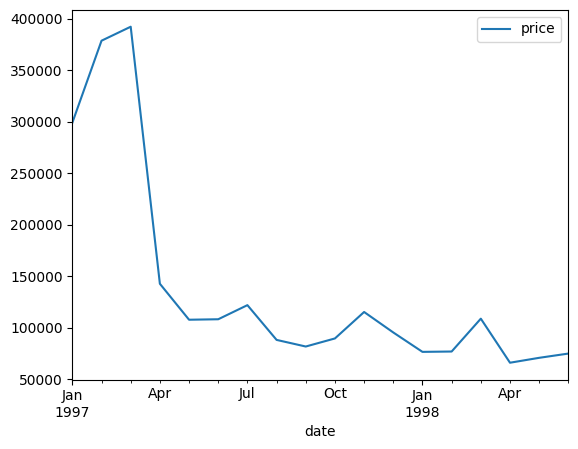

In [51]:
cdnow_df.reset_index() \
    .set_index('date') \
    [['price']] \
    .resample(rule='MS') \
    .sum() \
    .plot()

## Visualize: Individual Customer Purchases

In [52]:
# Select a subset of customer IDs
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[:12]

/tmp/ipykernel_474471/2476615928.py:26: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observ

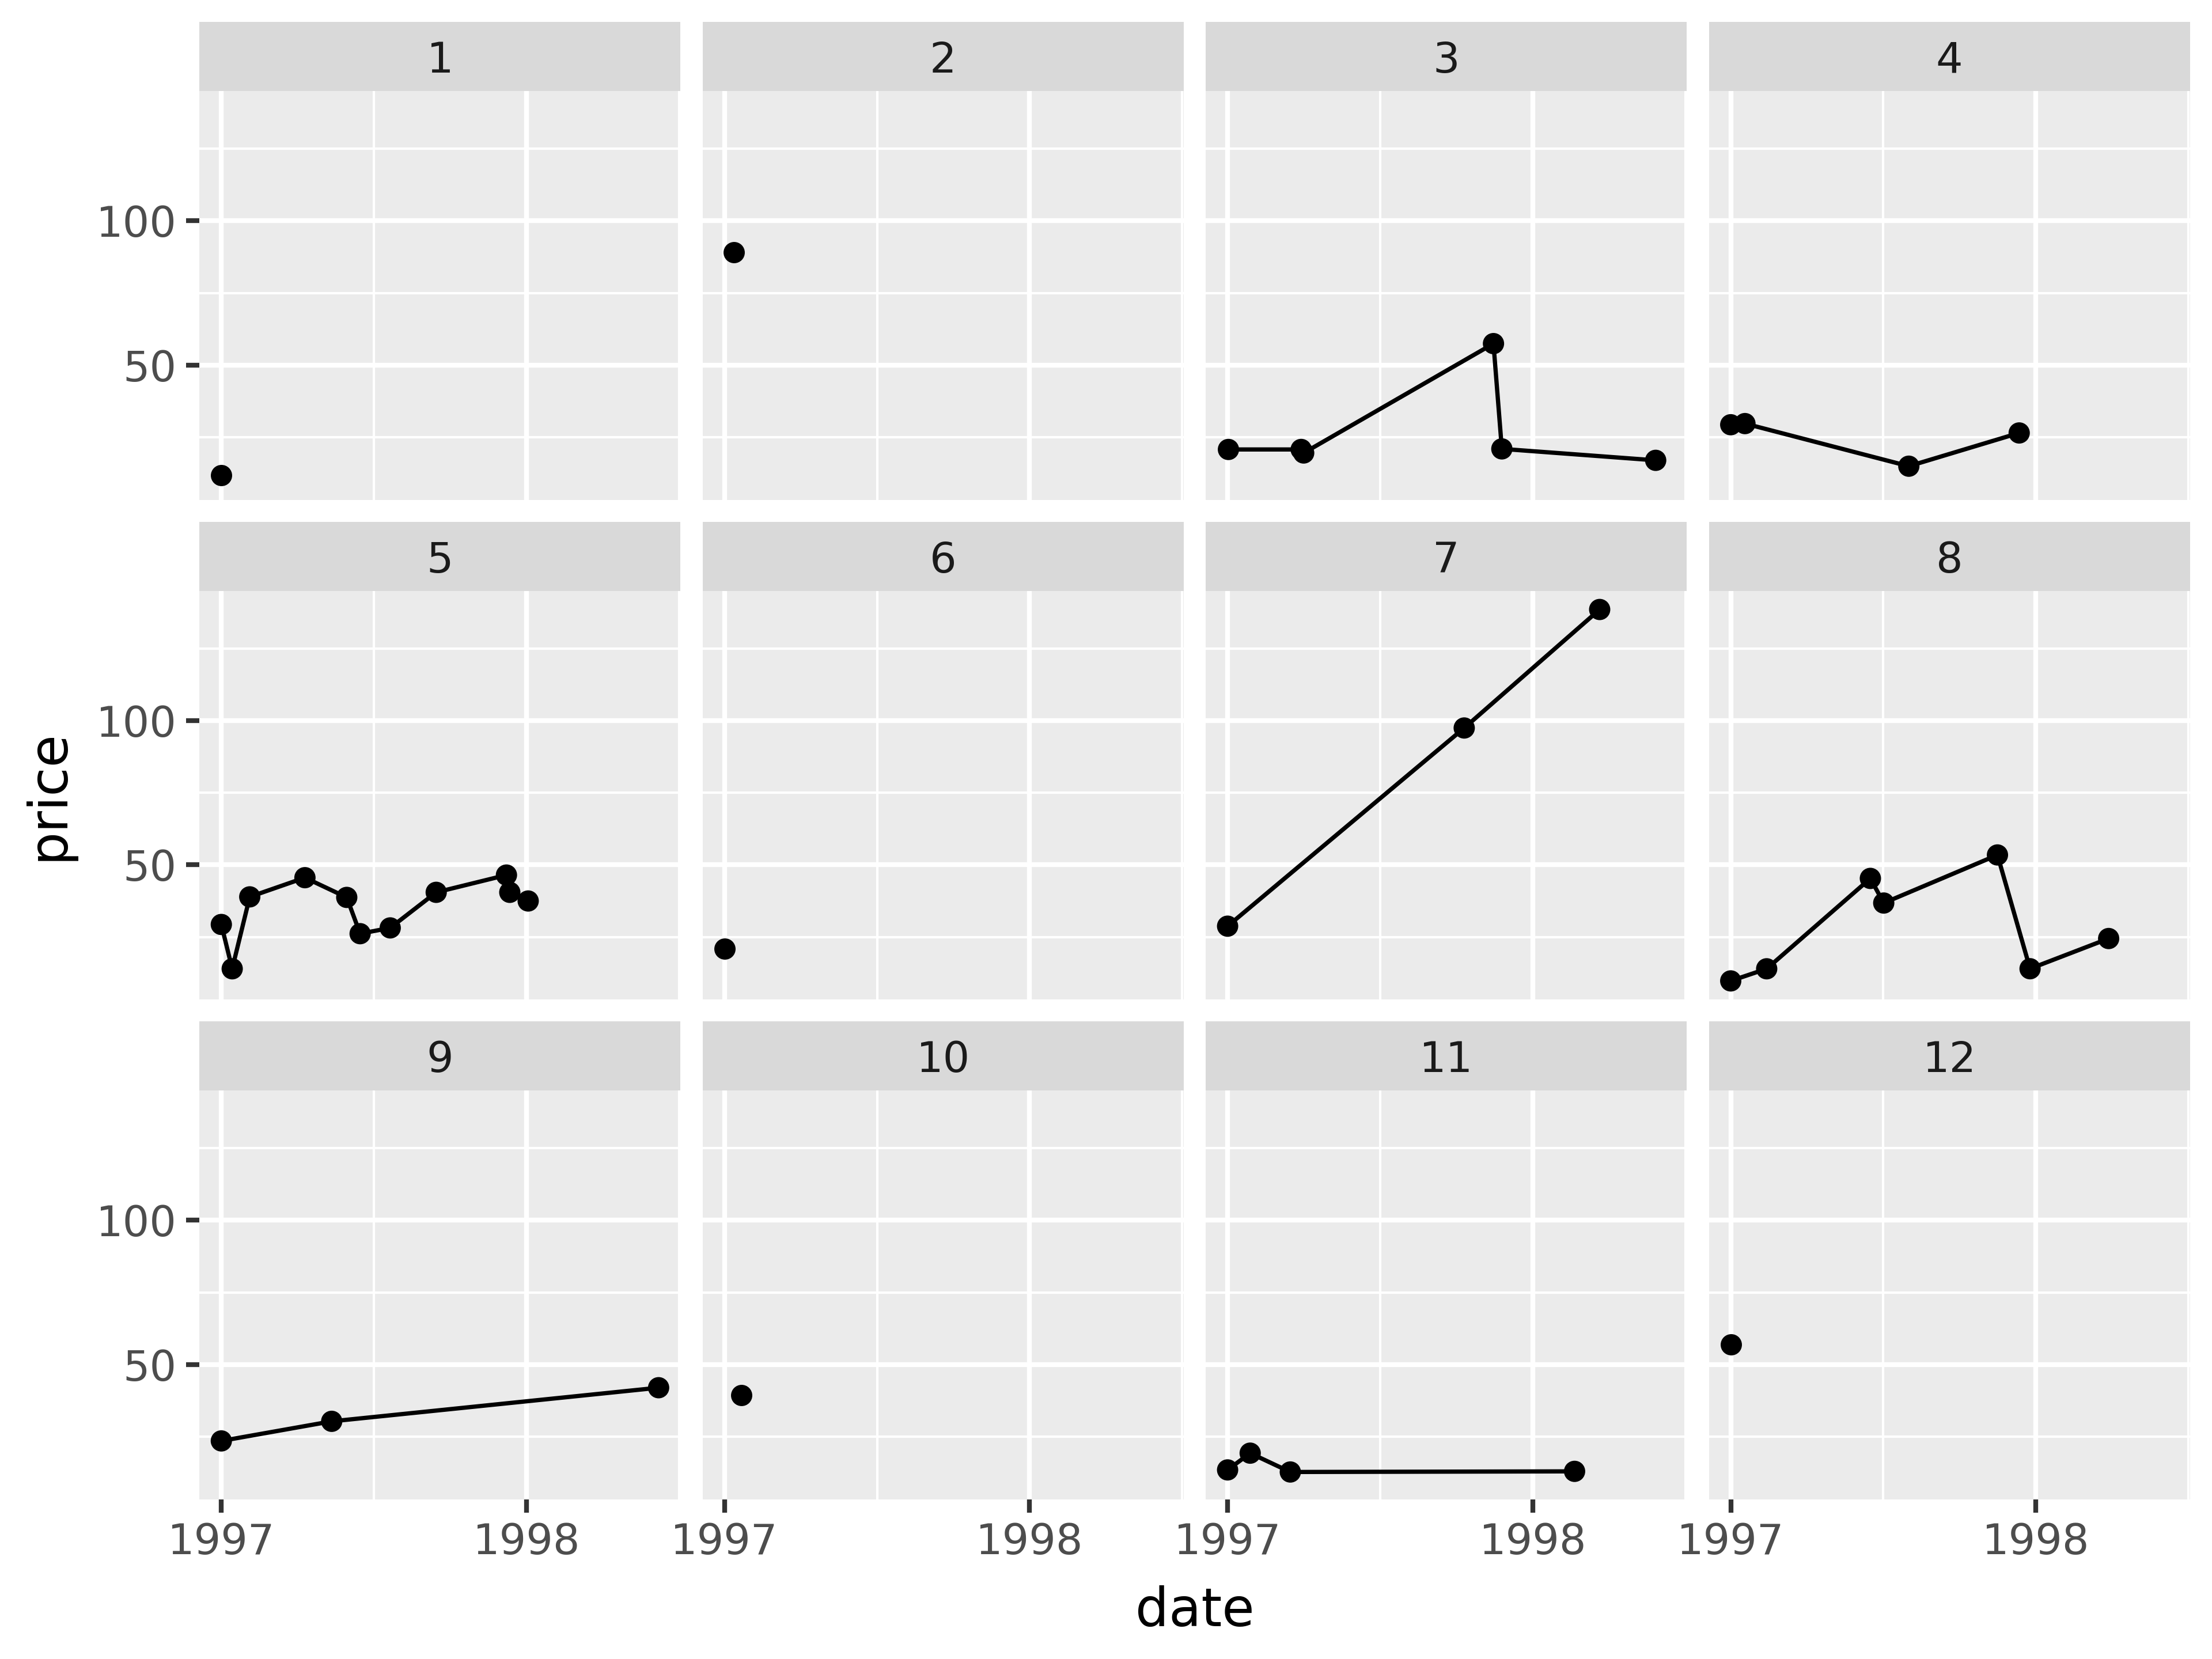

In [53]:
# ggplot API
# Filter the DataFrame for the selected customer IDs
cdnow_cust_id_subset_df = (
    cdnow_df[cdnow_df['customer_id'].isin(ids_selected)]
    .groupby(['customer_id', 'date'])
    .sum()
    .reset_index()
)

# Create the plot
plot = (
    pn.ggplot(
        cdnow_cust_id_subset_df,
        pn.aes('date', 'price', group='customer_id')
    )
    + pn.geom_line()
    + pn.geom_point()
    + pn.facet_wrap('~customer_id')
    + pn.scale_x_date(
        date_breaks='1 year',
        date_labels='%Y'
    )
)

# Display the plot
print(plot)

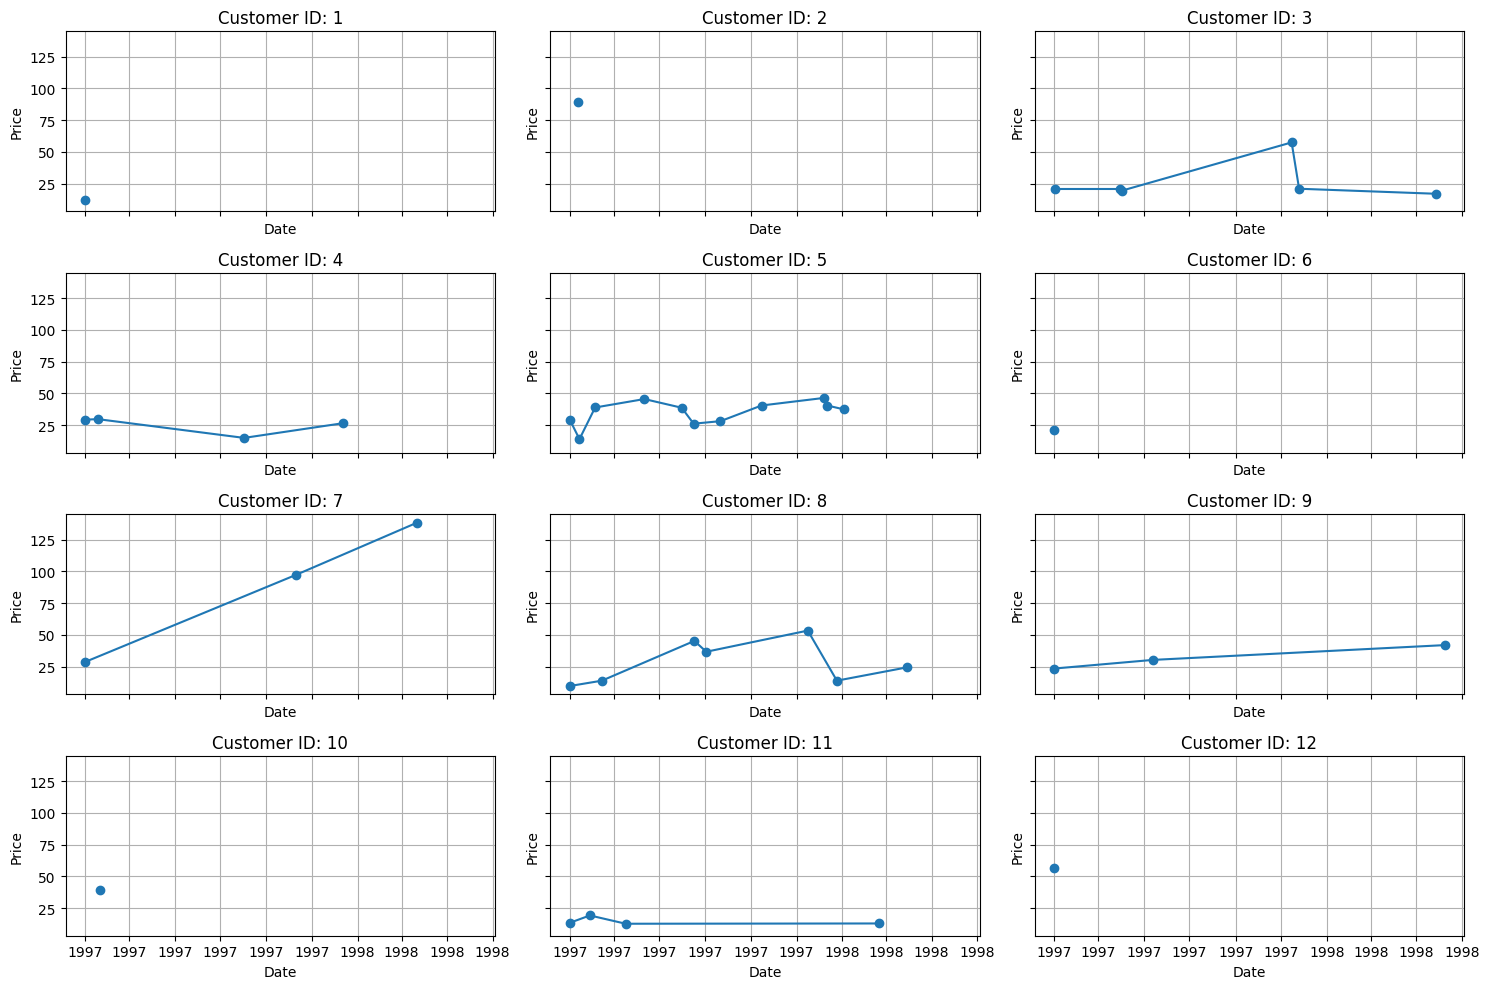

In [54]:
# Number of unique customers in the subset
unique_customers = cdnow_cust_id_subset_df['customer_id'].nunique()

# Define the number of rows and columns for the subplots
num_cols = 3
num_rows = (unique_customers + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, (customer_id, group) in zip(axes, cdnow_cust_id_subset_df.groupby('customer_id')):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-')
    ax.set_title(f'Customer ID: {customer_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    ax.grid(True) 

# Remove any empty subplots
for i in range(unique_customers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# 3.0 FEATURE ENGINEERING

Frame problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in the next 90-days? (Classification)

## 3.1 TIME SPLITTING (STAGE 1)

In [55]:
n_days = 90
max_date = cdnow_df['date'].max()

# Calculate the cutoff date
cutoff = max_date - pd.to_timedelta(n_days, unit='d')

In [56]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

In [57]:
temporal_in_df.head(3)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00


In [58]:
temporal_out_df.head(3)

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99


## 3.2 FEATURE ENGINEERING (RFM)

### Make Targets From Data

In [59]:
targets_df = (
    temporal_out_df
    .drop(['quantity','date'], axis=1) # must drop date to .sum()
    .groupby('customer_id')
    .sum()
    .rename({'price': 'spend_90_total'}, axis=1)
    .assign(spend_90_flag=1)  # Add a new column 'spend_90_flag' with value 1
)

In [60]:
targets_df.head(3)

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1


In [61]:
# From almost 70k to 3301
targets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3301 entries, 3 to 23561
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spend_90_total  3301 non-null   float64
 1   spend_90_flag   3301 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 77.4 KB


### Make Recency (Date) Features From 'in' Data

In [62]:
max_date = temporal_in_df['date'].max()

In [63]:
recency_features_df = (
    temporal_in_df
    #.drop(['quantity','price'], axis=1)
    [['customer_id','date']]
    .groupby('customer_id')
    .apply(lambda x: (x['date'].max() - max_date).days, include_groups=False)
    .to_frame(name='recency') # <- cause customer_id to become index
    .set_axis(['recency'], axis=1)
)

In [64]:
recency_features_df.head(3)

,recency
customer_id,
1,-455
2,-444
3,-127


In [65]:
recency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Frequency (Count) Features From 'in' Data

In [66]:
frequency_features_df = (
    temporal_in_df[['customer_id','date']]
    .groupby('customer_id')
    .count()
    .set_axis(['frequency'], axis=1)
)

In [67]:
frequency_features_df.head()

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11


In [68]:
frequency_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  23570 non-null  int64
dtypes: int64(1)
memory usage: 368.3 KB


### Make Price (Monetary) Features From 'in' Data

In [69]:
price_features_df = (
    temporal_in_df
    .groupby('customer_id')
    .aggregate({'price':['sum','mean']})
    .set_axis(['price_sum','price_mean'], axis=1)
)

In [70]:
price_features_df.head(3)

,price_sum,price_mean
customer_id,,
1,11.77,11.770
2,89.00,44.500
3,139.47,27.894


In [71]:
price_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price_sum   23570 non-null  float64
 1   price_mean  23570 non-null  float64
dtypes: float64(2)
memory usage: 552.4 KB


### 3.3 Combine Features

In [72]:
features_df = (
    pd.concat(
        [recency_features_df,frequency_features_df,price_features_df],axis=1
    )
    .merge(
        targets_df,
        left_index=True,
        right_index=True,
        how='left'
    )
    .fillna(0) # Customers that did not make a purchase show as NaN
)

In [73]:
features_df.head(3)

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455,1,11.77,11.770,0.00,0.0
2,-444,2,89.00,44.500,0.00,0.0
3,-127,5,139.47,27.894,16.99,1.0


In [74]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         23570 non-null  int64  
 1   frequency       23570 non-null  int64  
 2   price_sum       23570 non-null  float64
 3   price_mean      23570 non-null  float64
 4   spend_90_total  23570 non-null  float64
 5   spend_90_flag   23570 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


In [75]:
features_df.to_pickle('../artifacts/features_df.pkl')

# 4.0 MACHINE LEARNING

## Imports

In [76]:
import pandas as pd
# import cudf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

In [77]:
# !nvidia-smi

## 4.1 Next 90-Day Spend Prediction (Regression)

In [78]:
X = features_df[['recency','frequency','price_sum','price_mean']]

In [79]:
y_spend = features_df['spend_90_total']

In [80]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_spend, test_size=0.2, random_state=42)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((18856, 4), (4714, 4), (18856,), (4714,))

In [82]:
# Define the XGBRegressor with hyperparameters
xgb_reg_spec = XGBRegressor(
    objective='reg:squarederror',
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0,
    random_state=42
)

xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBRegressor
xgbreg_grid_search = GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=xgb_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5,
    n_jobs=-1
)

In [83]:
# Fit the model using the training data
xgbreg_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.5, 1],
                         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'lambda': [1, 1.5, 2, 3],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [84]:
# Define the CatBoostRegressor with hyperparameters
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    # task_type='GPU',
    random_seed=42,
    verbose=0  # Suppress CatBoost output
)

cat_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Grid search for CatBoostRegressor
cat_grid_search = GridSearchCV(
    estimator=cat_reg_spec,
    param_grid=cat_param_grid,
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5,
    n_jobs=6
)

In [85]:
# Fit the model using the training data
cat_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4ffc833910>,
             n_jobs=6,
             param_grid={'depth': [3, 4, 5, 6], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='neg_mean_absolute_error')

## Regression Interpretation

In [86]:
# Evaluate XGBRegressor on test set
xgb_best_model = xgbreg_grid_search.best_estimator_
xgb_y_pred = xgb_best_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
print("XGBRegressor Best MAE: ", xgb_mae)

# Evaluate CatBoostRegressor on test set
cat_reg_best_model = cat_grid_search.best_estimator_
cat_y_pred = cat_reg_best_model.predict(X_test)
cat_mae = mean_absolute_error(y_test, cat_y_pred)
print("CatBoostRegressor Best MAE: ", cat_mae)

# Print best parameters
print("Best parameters for XGBRegressor: ", xgbreg_grid_search.best_params_)
print("Best parameters for CatBoostRegressor: ", cat_grid_search.best_params_)


XGBRegressor Best MAE:  10.80781903628429
CatBoostRegressor Best MAE:  8.07588626966046
Best parameters for XGBRegressor:  {'alpha': 0.5, 'colsample_bytree': 1.0, 'lambda': 3, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best parameters for CatBoostRegressor:  {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.2}


In [87]:
# Additional statistics for the target variable
print(f"Range of target variable: {y_spend.min()} to {y_spend.max()}")
print(f"Mean of target variable: {y_spend.mean()}")
print(f"Standard deviation of target variable: {y_spend.std()}")

Range of target variable: 0.0 to 2512.91
Mean of target variable: 8.949271955876114
Standard deviation of target variable: 43.65695254305198


CatBoostRegressor has a better MAE than XGBRegressor and will be used to asses model fit.

**MAE vs. Mean of Target Variable:**

The MAE (8.07) being lower than the mean of the target variable (8.94) suggests that, on average, the errors your model makes are smaller than the average value of the target variable. This is a good sign, indicating that the model is not making large errors consistently.

**MAE vs. Standard Deviation of Target Variable:**

The standard deviation (43.65) is a measure of the spread or variability in the target variable. An MAE of 8.07 is significantly lower than the standard deviation, indicating that the model's errors are relatively small compared to the variability in the target data. This means the model is capturing a significant amount of the variability in the data and making predictions that are fairly close to the actual values.

## 4.2 Next 90-Day Spend Probability (Binary Classification)

In [88]:
x_class = features_df[['recency','frequency','price_sum','price_mean']]

In [89]:
y_prob = features_df['spend_90_flag']

In [90]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_class, y_prob, test_size=0.2, random_state=42)

In [91]:
# Define the XGBClassifier with hyperparameters
xgb_class_spec = XGBClassifier(
    objective='binary:logistic',
    # tree_method='hist', # gpu_hist depreciated
    # device='cuda', # now use this
    # gpu_id=0,
    random_state=42
)

xgb_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'lambda': [1, 1.5, 2, 3]   # L2 regularization term on weights
}

# Grid search for XGBClassifier
xgb_class_grid_search = GridSearchCV(
    estimator=xgb_class_spec,
    param_grid=xgb_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=-1
)

In [92]:
# Fit the model using the training data
xgb_class_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.5, 1],
                         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'lambda': [1, 1.5, 2, 3],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [93]:
# Define the CatBoostClassifier with hyperparameters
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0 
)

# Define the hyperparameter grid
cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Define the GridSearchCV object
cat_class_grid_search = GridSearchCV(
    estimator=cat_class_spec,
    param_grid=cat_class_param_grid,
    scoring='roc_auc',
    refit=True,
    cv=5,
    n_jobs=6
)


In [94]:
# Fit the model using the training data
cat_class_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f4f002e96d0>,
             n_jobs=6,
             param_grid={'depth': [3, 4, 5, 6], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5, 7],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3]},
             scoring='roc_auc')

## Classification Interpretation

In [95]:
from sklearn.metrics import roc_auc_score, mean_absolute_error

In [96]:
# Evaluate XGBClassifier on test set
xgb_best_model = xgb_class_grid_search.best_estimator_
xgb_y_pred_proba = xgb_best_model.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)
print("XGBClassifier Best ROC AUC: ", xgb_roc_auc)

# Evaluate CatBoostClassifier on test set
cat_class_best_model = cat_class_grid_search.best_estimator_
cat_y_pred_proba = cat_class_best_model.predict_proba(X_test)[:, 1]
cat_roc_auc = roc_auc_score(y_test, cat_y_pred_proba)
print("CatBoostClassifier Best ROC AUC: ", cat_roc_auc)

# Print best parameters
print("Best parameters for XGBClassifier: ", xgb_class_grid_search.best_params_)
print("Best parameters for CatBoostClassifier: ", cat_class_grid_search.best_params_)

XGBClassifier Best ROC AUC:  0.8456916660776137
CatBoostClassifier Best ROC AUC:  0.8466781458377513
Best parameters for XGBClassifier:  {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best parameters for CatBoostClassifier:  {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb_class_y_pred = xgb_best_model.predict(X_test)
cat_class_y_pred = cat_class_best_model.predict(X_test)

print("XGBClassifier Accuracy: ", accuracy_score(y_test, xgb_class_y_pred))
print("XGBClassifier Precision: ", precision_score(y_test, xgb_class_y_pred))
print("XGBClassifier Recall: ", recall_score(y_test, xgb_class_y_pred))
print("XGBClassifier F1 Score: ", f1_score(y_test, xgb_class_y_pred))
print('')
print("CatBoostClassifier Accuracy: ", accuracy_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Precision: ", precision_score(y_test, cat_class_y_pred))
print("CatBoostClassifier Recall: ", recall_score(y_test, cat_class_y_pred))
print("CatBoostClassifier F1 Score: ", f1_score(y_test, cat_class_y_pred))

XGBClassifier Accuracy:  0.8792957148918116
XGBClassifier Precision:  0.6757679180887372
XGBClassifier Recall:  0.29464285714285715
XGBClassifier F1 Score:  0.41036269430051814

CatBoostClassifier Accuracy:  0.8807806533729317
CatBoostClassifier Precision:  0.6740506329113924
CatBoostClassifier Recall:  0.3169642857142857
CatBoostClassifier F1 Score:  0.4311740890688259


**Model Assesment**

* Accuracy: Both models perform similarly.
* Precision: Both models have similar precision, indicating a similar rate of false positives.
* Recall: CatBoostClassifier has a higher recall, meaning it is better at identifying true positives.
* F1 Score: CatBoostClassifier has a higher F1 score, indicating a better balance between precision and recall.

**Conclusion:** Overall, based on these metrics, CatBoostClassifier slightly outperforms XGBClassifier due to its better recall and F1 score.

## 4.3 FEATURE IMPORTANCE

### Regression

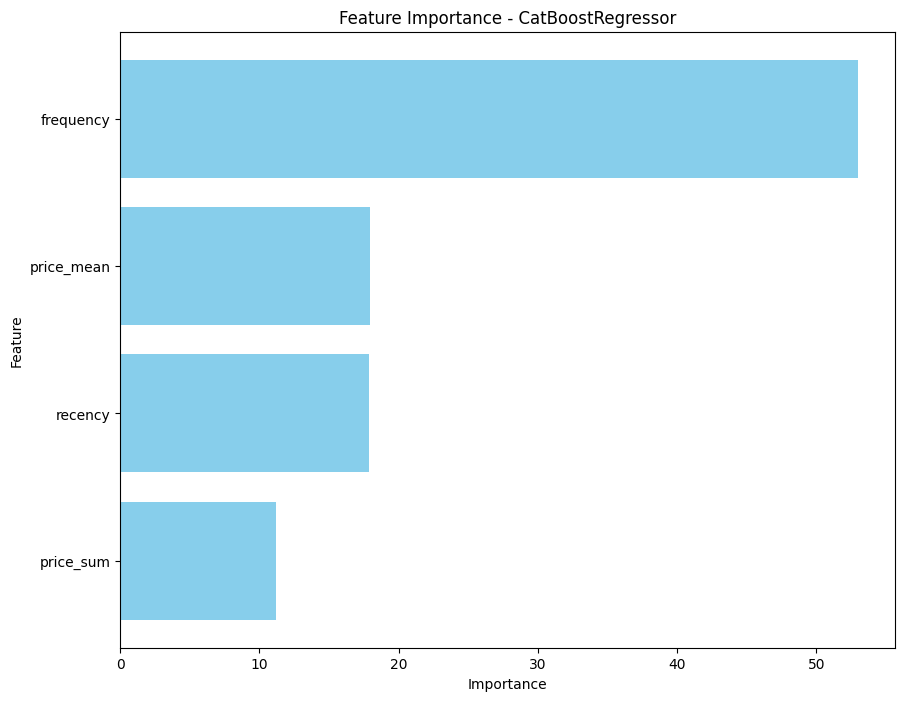

In [98]:
# Extract feature importance from CatBoostRegressor
cat_reg_feature_importance = cat_reg_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_reg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_reg_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_reg_importance_df['Feature'], cat_reg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

### Classification

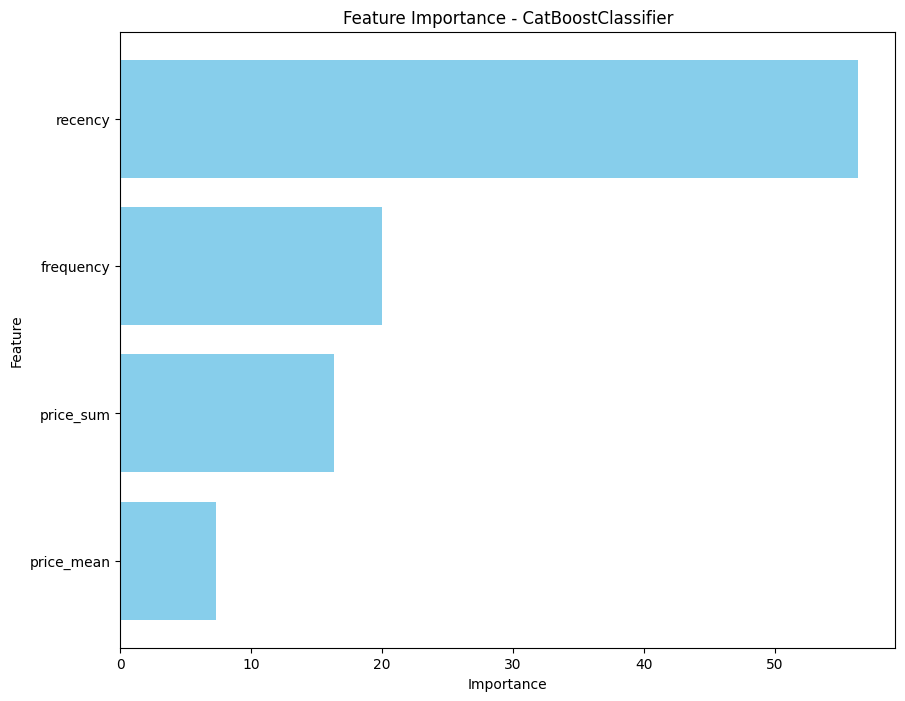

In [99]:
# Extract feature importance from CatBoostClassifier
cat_class_feature_importance = cat_class_best_model.get_feature_importance()
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for visualization
cat_class_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_class_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_class_importance_df['Feature'], cat_class_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostClassifier')
plt.gca().invert_yaxis()
plt.show()

# 5.0 FINAL MODEL

### Imports

In [52]:
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix,precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import joblib
#import cupy, cudf

### Train Final Model

In [8]:
# Data prep
features_df = pd.read_pickle('../artifacts/features_df.pkl')
# features_df = cudf.DataFrame.from_pandas(pandas_df)
y_class = features_df['spend_90_flag']
y_reg = features_df['spend_90_total']
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# params
cv = 10
n_jobs = -1

In [9]:
def perform_grid_search(model, param_grid, X, y, scoring, cv=cv,n_jobs=n_jobs):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        refit=True,
        cv=cv,
        n_jobs=n_jobs
    )
    grid_search.fit(X, y)
    print(f"Best parameters for {model.__class__.__name__}:", grid_search.best_params_)
    return grid_search.best_estimator_

In [10]:
# Define parameter grids
cat_class_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    #'border_count': [32, 64, 128],
    #'random_strength': [1, 5, 10]
}

cat_reg_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 4, 5, 6],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    #'border_count': [32, 64, 128],
    #'random_strength': [1, 5, 10]
}


In [11]:
# Perform grid search with cross-validation for the classifier
cat_class_spec = CatBoostClassifier(
    loss_function='Logloss',
    random_seed=42,
    verbose=0,
    #task_type='GPU',
    #devices='0'
)
cat_class_best_model = perform_grid_search(cat_class_spec, cat_class_param_grid, X, y_class, scoring='roc_auc')

# Generate predictions for the entire dataset
cat_class_y_pred_proba = cat_class_best_model.predict_proba(X)[:, 1]

# Perform grid search with cross-validation for the regressor
cat_reg_spec = CatBoostRegressor(
    loss_function='MAE',
    random_seed=42,
    verbose=0,
    #task_type='GPU',
    #devices='0'
)
cat_reg_best_model = perform_grid_search(cat_reg_spec, cat_reg_param_grid, X, y_reg, scoring='neg_mean_absolute_error')

# Generate regression predictions for the entire dataset
cat_reg_y_pred = cat_reg_best_model.predict(X)

# Save the models using joblib
joblib.dump(cat_class_best_model, '../models/cat_class_best_model.pkl')
joblib.dump(cat_reg_best_model, '../models/cat_reg_best_model.pkl')

# Print best parameters for both models
print("Best parameters for CatBoostClassifier:", cat_class_best_model.get_params())
print("Best parameters for CatBoostRegressor:", cat_reg_best_model.get_params())

Best parameters for CatBoostClassifier: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best parameters for CatBoostRegressor: {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
Best parameters for CatBoostClassifier: {'loss_function': 'Logloss', 'random_seed': 42, 'verbose': 0, 'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best parameters for CatBoostRegressor: {'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0, 'depth': 5, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}


In [12]:
# Save (pickle) the models
joblib.dump(cat_class_best_model, '../models/catboost_classifier.pkl')
joblib.dump(cat_reg_best_model, '../models/catboost_regressor.pkl')

print("Models saved successfully.")

Models saved successfully.


In [14]:
# Save the regression predictions
joblib.dump(cat_reg_y_pred, '../artifacts/cat_reg_y_pred.pkl')

# Save the classification predictions
joblib.dump(cat_class_y_pred_proba, '../artifacts/cat_class_y_pred_proba.pkl')

['../artifacts/cat_class_y_pred_proba.pkl']

In [15]:
# Load (unpickle) the models
loaded_cat_class_model = joblib.load('../models/catboost_classifier.pkl')
loaded_cat_reg_model = joblib.load('../models/catboost_regressor.pkl')

print("Models loaded successfully.")

Models loaded successfully.


### Combine Features

In [16]:
# Load (unpickle) the predictions
cat_reg_y_pred = joblib.load('../artifacts/cat_reg_y_pred.pkl')
cat_class_y_pred_proba = joblib.load('../artifacts/cat_class_y_pred_proba.pkl')

In [17]:
# Print shape to confirm
print(f"cat_reg_y_pred shape: {cat_reg_y_pred.shape}")

# Create DataFrame for the regression predictions
cat_reg_predictions_df = pd.DataFrame(cat_reg_y_pred, columns=['pred_spend'])

cat_reg_y_pred shape: (23570,)


In [18]:
# Print shape to confirm
print(f"cat_class_y_pred_proba shape: {cat_class_y_pred_proba.shape}")

# Create DataFrame for the predicted probabilities
cat_class_predictions_df = pd.DataFrame(cat_class_y_pred_proba, columns=['pred_prob'])

cat_class_y_pred_proba shape: (23570,)


In [20]:
# Ensure that the DataFrames have the same number of rows
assert len(cat_class_predictions_df) == len(cat_reg_predictions_df) == len(features_df), "Mismatch in number of rows"

# Combine the predicted probabilities, regression predictions, and original features
predictions_df = pd.concat(
    [
        cat_class_predictions_df.reset_index(drop=True),
        cat_reg_predictions_df.reset_index(drop=True),
        features_df.reset_index(drop=True)
    ], axis=1
)

In [21]:
predictions_df

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.025410,1.000000e-06,-455,1,11.77,11.770000,0.00,0.0
1,0.039112,-1.812085e-07,-444,2,89.00,44.500000,0.00,0.0
2,0.268981,1.963717e-07,-127,5,139.47,27.894000,16.99,1.0
3,0.280221,5.384533e-07,-110,4,100.50,25.125000,0.00,0.0
4,0.568317,1.217201e+01,-88,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...
23565,0.042189,1.000000e-06,-372,1,36.00,36.000000,0.00,0.0
23566,0.041057,1.000000e-06,-372,1,20.97,20.970000,0.00,0.0
23567,0.110423,2.490282e-08,-344,3,121.70,40.566667,0.00,0.0
23568,0.046135,1.000000e-06,-372,1,25.74,25.740000,0.00,0.0


In [22]:
predictions_df.to_pickle('../artifacts/predictions_df.pkl')

### Predictive Accuracy Analysis

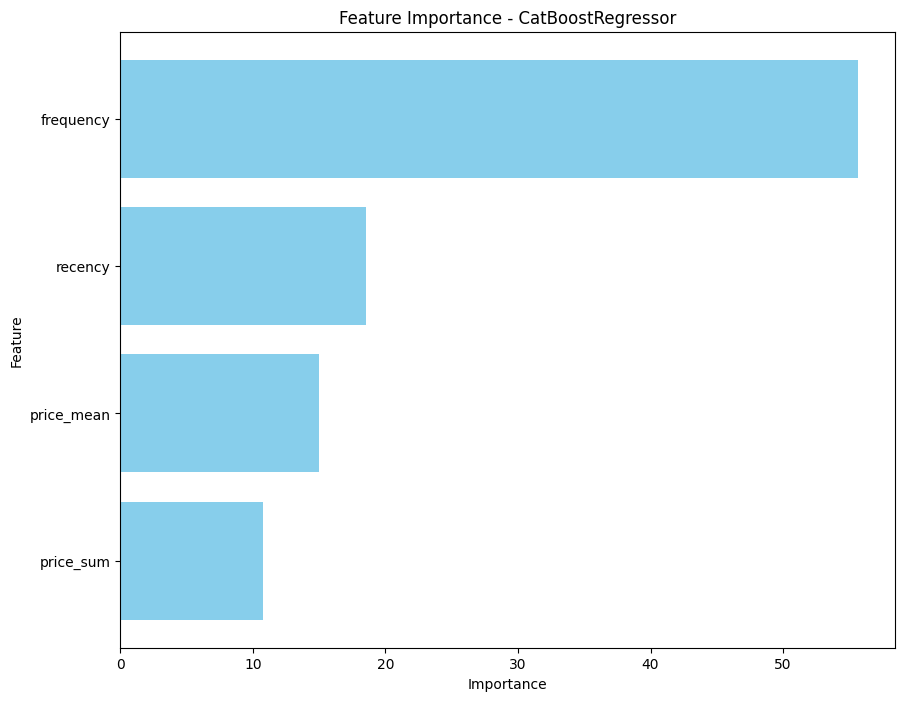

In [23]:
# Extract feature importance from CatBoostRegressor
cat_reg_feature_importance = cat_reg_best_model.get_feature_importance()
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
cat_reg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_reg_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_reg_importance_df['Feature'], cat_reg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

In [24]:
cat_reg_importance_df.to_pickle('../artifacts/cat_reg_importance_df.pkl')

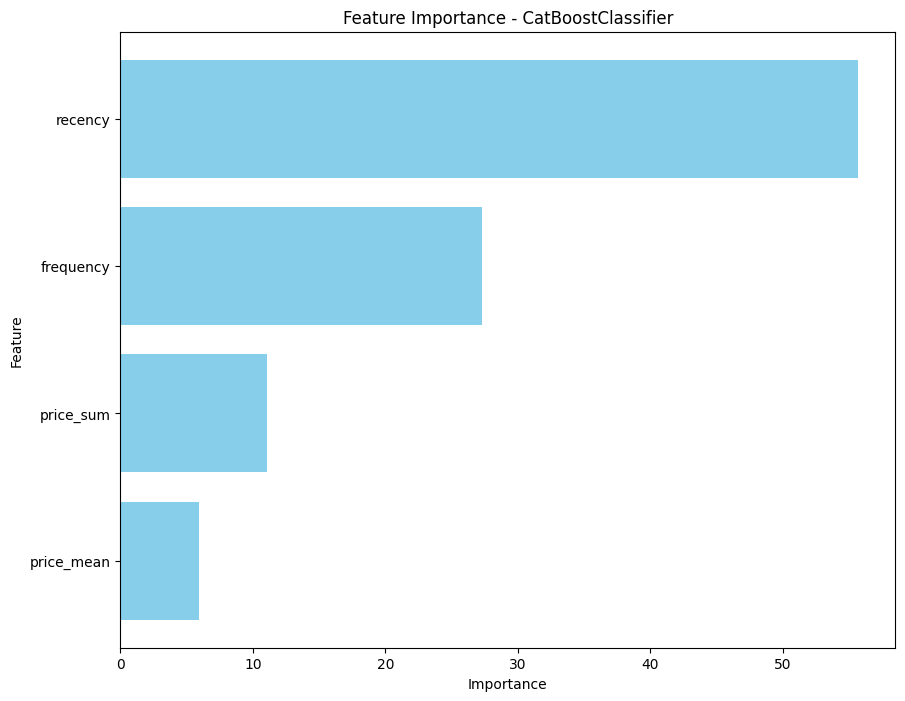

In [25]:
# Extract feature importance from CatBoostClassifier
cat_class_feature_importance = cat_class_best_model.get_feature_importance()
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
cat_class_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': cat_class_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(cat_class_importance_df['Feature'], cat_class_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoostClassifier')
plt.gca().invert_yaxis()
plt.show()

In [26]:
cat_class_importance_df.to_pickle('../artifacts/cat_class_importance_df.pkl')

In [31]:
# True Positives
true_positives = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] > 0)
]

# False Positives
false_positives = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] == 0)
]

# True Negatives
true_negatives = predictions_df[
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] == 0)
]

# False Negatives
false_negatives = predictions_df[
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median()) & 
    (predictions_df['spend_90_total'] > 0)
]


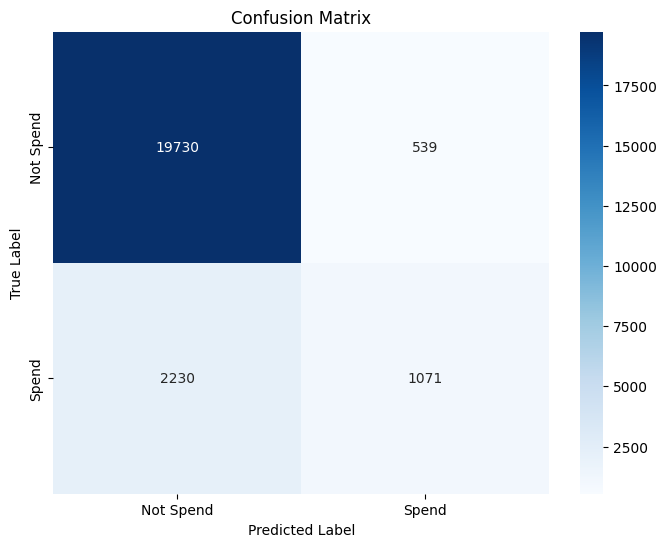

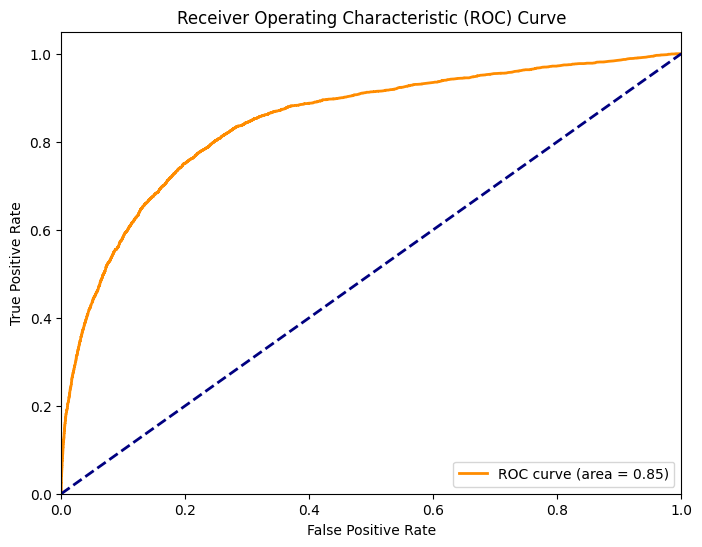

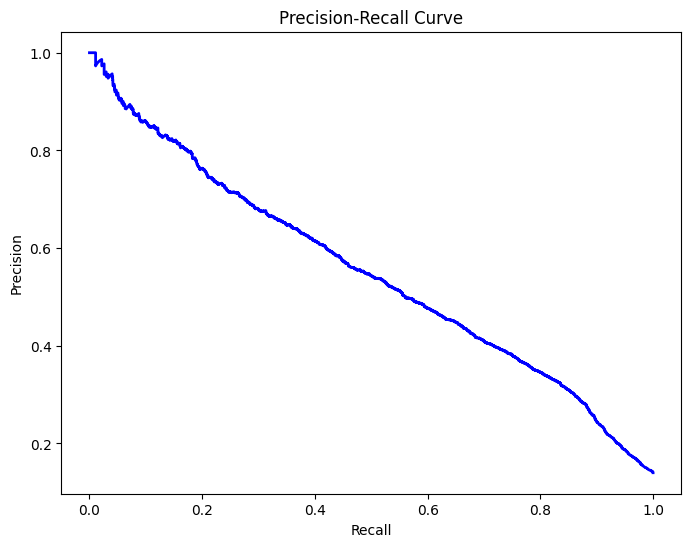

Classification Report:
              precision    recall  f1-score   support

   Not Spend       0.90      0.97      0.93     20269
       Spend       0.67      0.32      0.44      3301

    accuracy                           0.88     23570
   macro avg       0.78      0.65      0.69     23570
weighted avg       0.87      0.88      0.86     23570



In [37]:
# Define true labels and predicted probabilities
y_true = predictions_df['spend_90_flag']
y_pred_prob = predictions_df['pred_prob']

# Define predicted labels based on a threshold (e.g., 0.5)
threshold = 0.5
y_pred_label = (y_pred_prob >= threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_label)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

# Classification Report
class_report = classification_report(y_true, y_pred_label, target_names=['Not Spend', 'Spend'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spend', 'Spend'], yticklabels=['Not Spend', 'Spend'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Print Classification Report
print("Classification Report:")
print(class_report)

Mean Absolute Error (MAE): 8.016183395994753
Root Mean Squared Error (RMSE): 36.80155420641939
R-squared: 0.289369385599882


/home/blackitalian/miniconda3/envs/cdnow/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


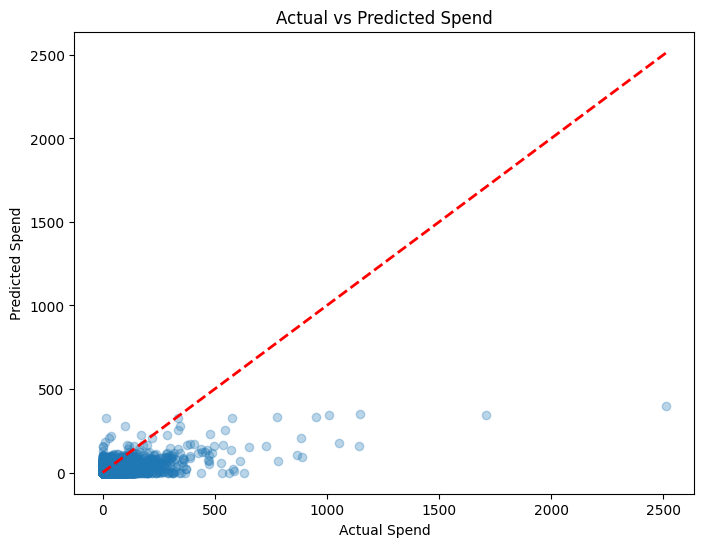

In [38]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_reg, cat_reg_y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_reg, cat_reg_y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared
r2 = r2_score(y_reg, cat_reg_y_pred)
print(f"R-squared: {r2}")

# Plot Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, cat_reg_y_pred, alpha=0.3)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Spend')
plt.ylabel('Predicted Spend')
plt.title('Actual vs Predicted Spend')
plt.show()

### Model Assessment

**Classification**

* MAE of 8.016 suggests the average prediction error is moderate.
* RMSE of 36.802 indicates there are some large prediction errors, suggesting the presence of significant outliers or that the model is not handling some of the data points well.
* R-squared of 0.289 indicates that the model explains only a small portion of the variance in the target variable, suggesting it is not very effective in capturing the underlying patterns in the data.


# 6.0 BUSINESS VALUE

In [39]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

In [40]:
predictions_df = pd.read_pickle('../artifacts/predictions_df.pkl')

### RFM Analysis

In [41]:
# Recency segmentation
recent_customers = predictions_df[predictions_df['recency'] < 30]
average_customers = predictions_df[(predictions_df['recency'] >= 30) & (predictions_df['recency'] < 90)]
old_customers = predictions_df[predictions_df['recency'] >= 90]

# Frequency segmentation
frequent_customers = predictions_df[predictions_df['frequency'] > predictions_df['frequency'].median()]
infrequent_customers = predictions_df[predictions_df['frequency'] <= predictions_df['frequency'].median()]

# Monetary segmentation
high_value_customers = predictions_df[predictions_df['price_sum'] > predictions_df['price_sum'].median()]
low_value_customers = predictions_df[predictions_df['price_sum'] <= predictions_df['price_sum'].median()]

#### Visualize Recency Segmentation

/tmp/ipykernel_1193938/1927084951.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='recency', data=predictions_df, palette='coolwarm')


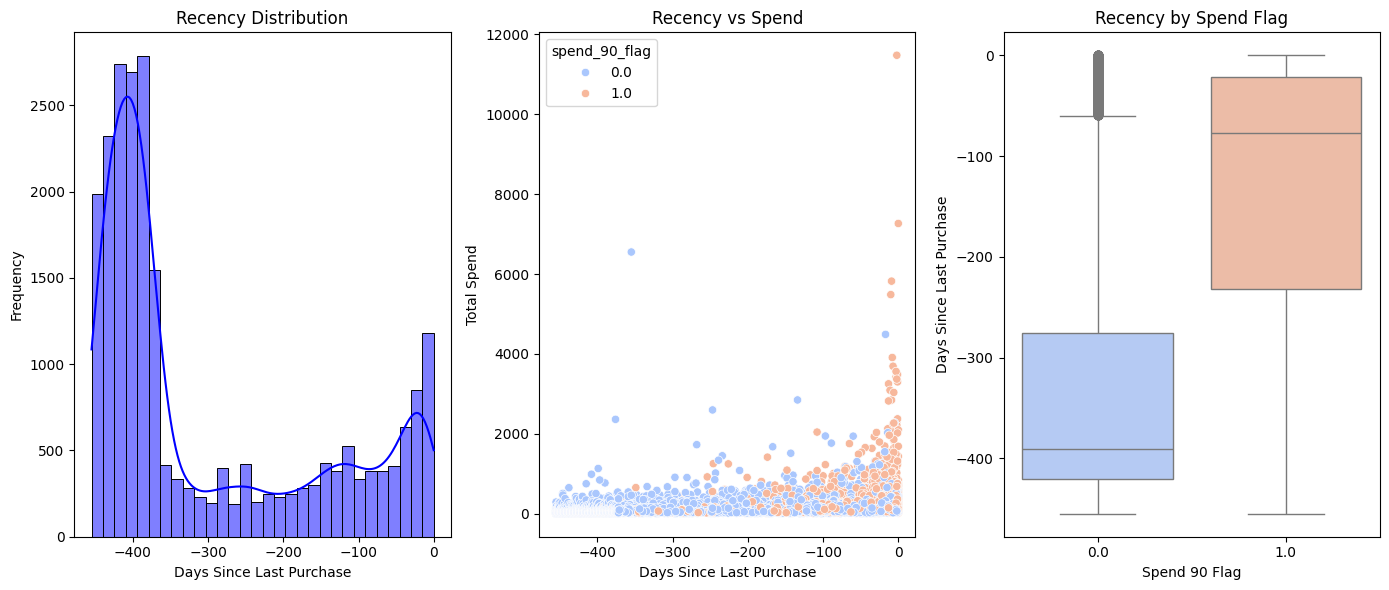

In [42]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Recency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['recency'], bins=30, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')

# Plot Recency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='recency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Recency vs Spend')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Spend')

# Plot Recency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='recency', data=predictions_df, palette='coolwarm')
plt.title('Recency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Days Since Last Purchase')

plt.tight_layout()
plt.show()


 #### Visualize Frequency Segmentation

/tmp/ipykernel_1193938/1848799178.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='frequency', data=predictions_df, palette='coolwarm')


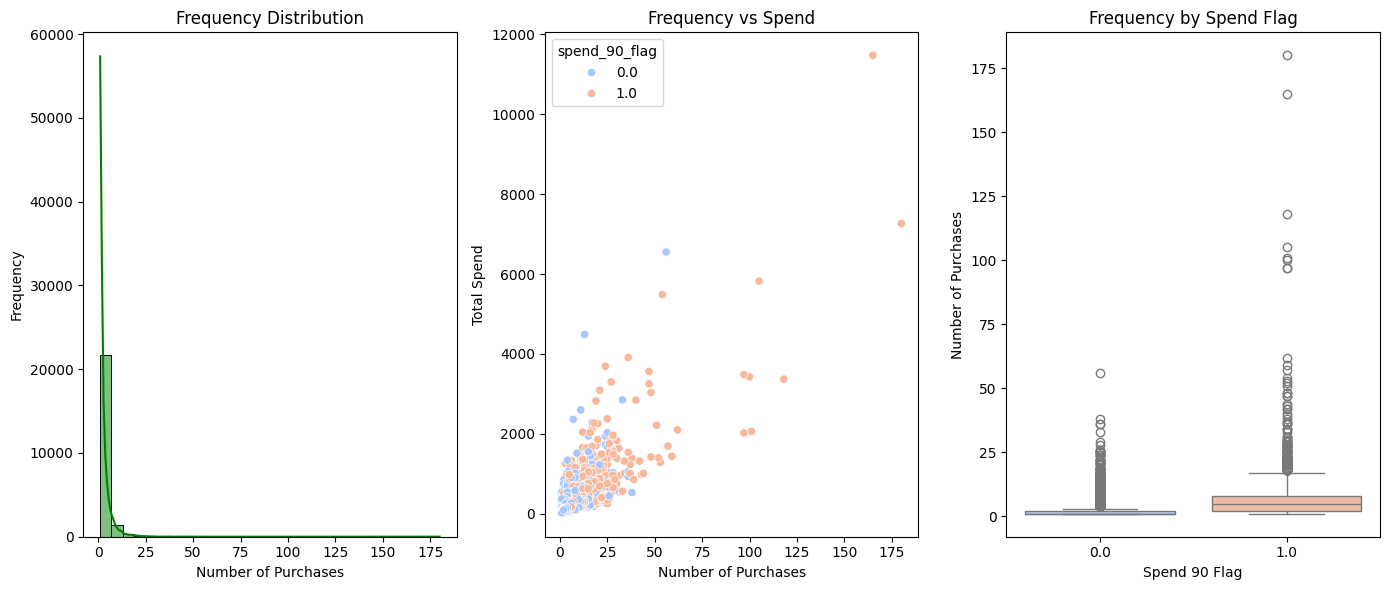

In [43]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Frequency histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['frequency'], bins=30, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Frequency')

# Plot Frequency scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='frequency', y='price_sum', hue='spend_90_flag', palette='coolwarm')
plt.title('Frequency vs Spend')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spend')

# Plot Frequency box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='frequency', data=predictions_df, palette='coolwarm')
plt.title('Frequency by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

#### Visualize Monetary Segmentation

/tmp/ipykernel_1193938/2471236298.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spend_90_flag', y='price_sum', data=predictions_df, palette='coolwarm')


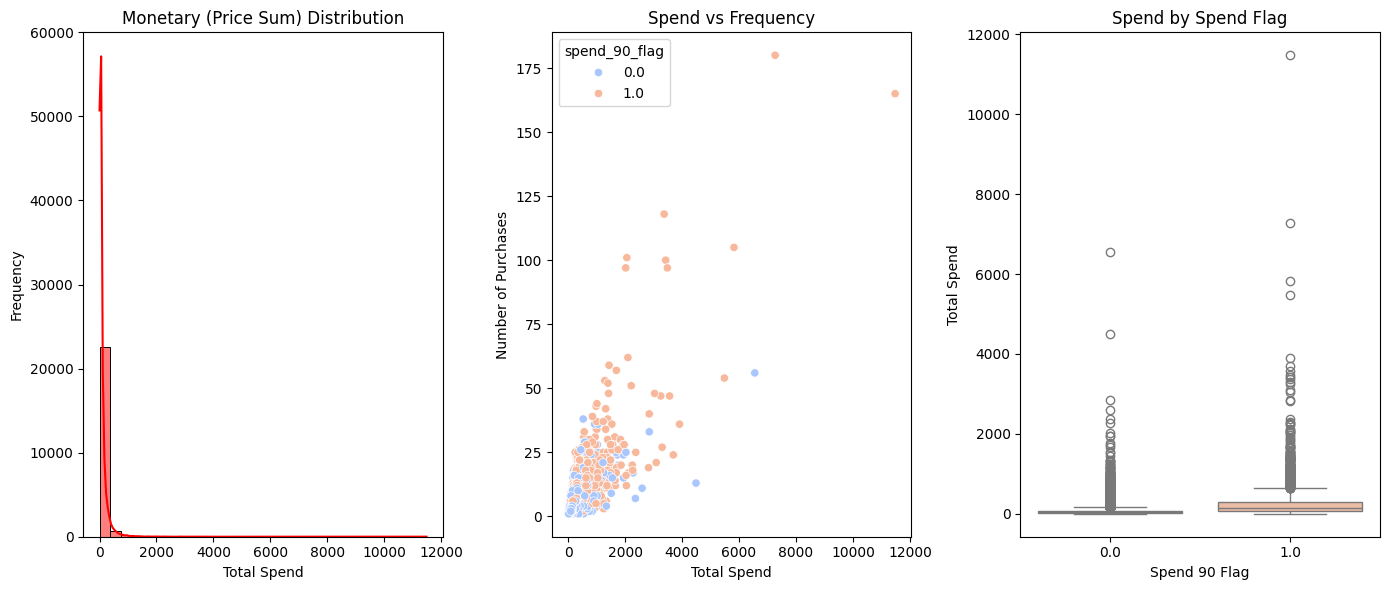

In [44]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot Monetary histogram
plt.subplot(1, 3, 1)
sns.histplot(predictions_df['price_sum'], bins=30, kde=True, color='red')
plt.title('Monetary (Price Sum) Distribution')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')

# Plot Monetary scatter plot
plt.subplot(1, 3, 2)
sns.scatterplot(data=predictions_df, x='price_sum', y='frequency', hue='spend_90_flag', palette='coolwarm')
plt.title('Spend vs Frequency')
plt.xlabel('Total Spend')
plt.ylabel('Number of Purchases')

# Plot Monetary box plot
plt.subplot(1, 3, 3)
sns.boxplot(x='spend_90_flag', y='price_sum', data=predictions_df, palette='coolwarm')
plt.title('Spend by Spend Flag')
plt.xlabel('Spend 90 Flag')
plt.ylabel('Total Spend')

plt.tight_layout()
plt.show()

### Customer Segmentation

In [45]:
# High Probability & High Spend
high_prob_high_spend = predictions_df[
    (predictions_df['pred_prob'] > 0.7) & 
    (predictions_df['pred_spend'] > predictions_df['pred_spend'].median())
]

# Low Probability & Low Spend
low_prob_low_spend = predictions_df[
    (predictions_df['pred_prob'] <= 0.7) & 
    (predictions_df['pred_spend'] <= predictions_df['pred_spend'].median())
]

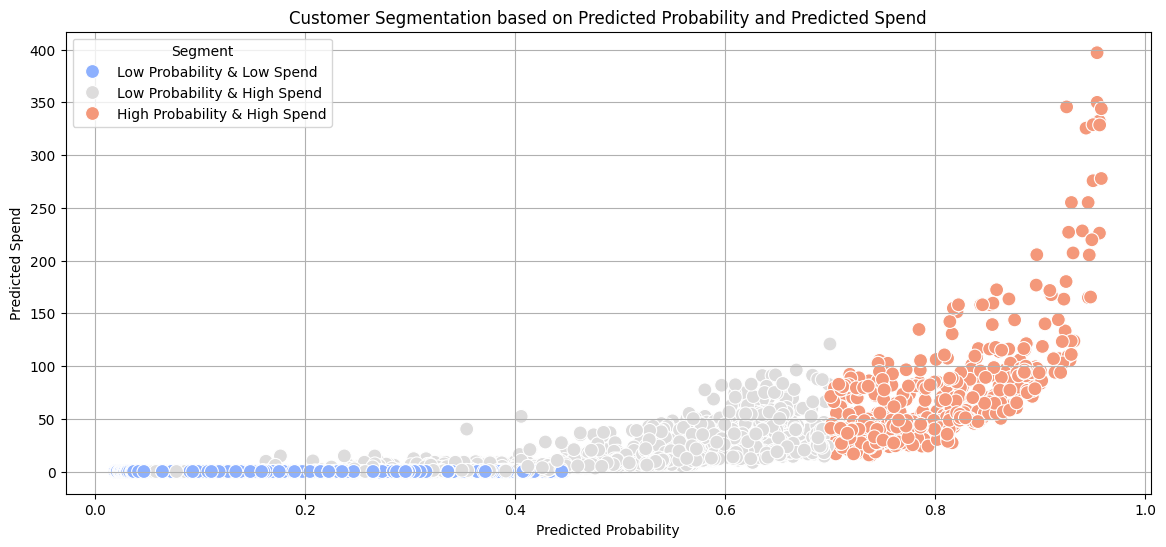

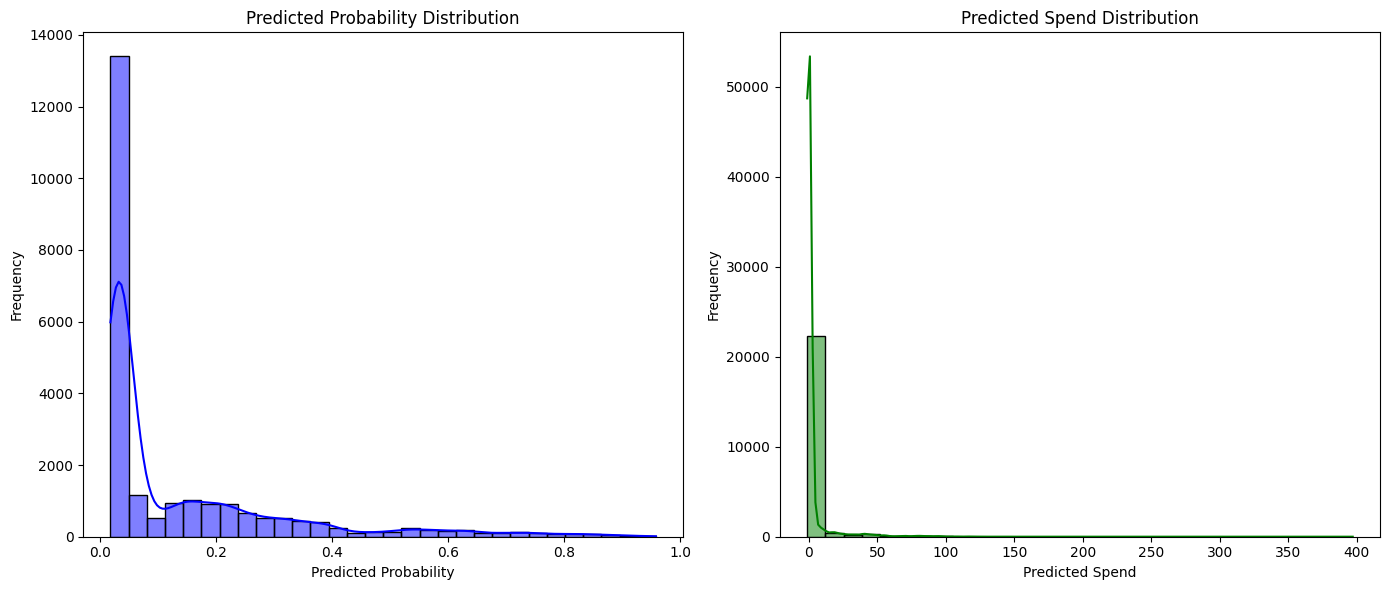

In [46]:
# Define the threshold values for high and low segmentation
prob_threshold = 0.7
spend_threshold = predictions_df['pred_spend'].median()

# Define segments
predictions_df['Segment'] = 'Low Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'High Probability & High Spend'
predictions_df.loc[(predictions_df['pred_prob'] > prob_threshold) & (predictions_df['pred_spend'] <= spend_threshold), 'Segment'] = 'High Probability & Low Spend'
predictions_df.loc[(predictions_df['pred_prob'] <= prob_threshold) & (predictions_df['pred_spend'] > spend_threshold), 'Segment'] = 'Low Probability & High Spend'

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Scatter plot for customer segmentation
sns.scatterplot(data=predictions_df, x='pred_prob', y='pred_spend', hue='Segment', palette='coolwarm', s=100)
plt.title('Customer Segmentation based on Predicted Probability and Predicted Spend')
plt.xlabel('Predicted Probability')
plt.ylabel('Predicted Spend')
plt.legend(title='Segment')
plt.grid(True)
plt.show()

# Histograms for predicted probability and predicted spend
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for predicted probability
sns.histplot(predictions_df['pred_prob'], bins=30, kde=True, color='blue', ax=ax[0])
ax[0].set_title('Predicted Probability Distribution')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Frequency')

# Histogram for predicted spend
sns.histplot(predictions_df['pred_spend'], bins=30, kde=True, color='green', ax=ax[1])
ax[1].set_title('Predicted Spend Distribution')
ax[1].set_xlabel('Predicted Spend')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Which customers have the highest spend probability in the next 90-days?

In [47]:
predictions_df.sort_values('pred_prob', ascending=False).head(10)

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
14047,0.958242,344.014260,0,180,7267.15,40.373056,1709.18,1.0,High Probability & High Spend
10078,0.958204,277.826985,0,62,2100.38,33.877097,100.43,1.0,High Probability & High Spend
22060,0.956654,328.593002,-2,118,3371.80,28.574576,577.10,1.0,High Probability & High Spend
498,0.956449,332.403348,-3,100,3427.55,34.275500,951.00,1.0,High Probability & High Spend
709,0.956448,226.036104,-2,51,2216.45,43.459804,285.85,1.0,High Probability & High Spend
3048,0.956330,332.403348,-1,97,3484.03,35.917835,778.82,1.0,High Probability & High Spend
7982,0.954234,350.040487,-9,105,5824.14,55.468000,1148.93,1.0,High Probability & High Spend
7591,0.954173,397.088242,-2,165,11478.02,69.563758,2512.91,1.0,High Probability & High Spend
19596,0.950396,328.843269,-1,97,2023.00,20.855670,334.57,1.0,High Probability & High Spend
2483,0.950357,275.693723,0,59,1438.93,24.388644,345.43,1.0,High Probability & High Spend


### Which customers have recently purchases but are unlikely to buy?

* Incentivize actions to increase probability.
* Provide discounts, encourage referring a friend, nurture by letting them know what's coming.

In [48]:
# customers that purchased in the last year but are unlikely to make another purchase
drop_out = predictions_df[
    (predictions_df['recency'] > -90) & 
    (predictions_df['pred_prob'] < 0.20)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
drop_out

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
10053,0.199943,-9.978156e-07,-35,2,42.15,21.075000,0.00,0.0,Low Probability & Low Spend
12122,0.199887,-8.182980e-07,-83,3,33.23,11.076667,0.00,0.0,Low Probability & Low Spend
19373,0.199787,3.562127e-07,-44,2,155.40,77.700000,0.00,0.0,Low Probability & Low Spend
16839,0.199778,-9.978156e-07,-32,2,42.47,21.235000,0.00,0.0,Low Probability & Low Spend
8517,0.199717,9.121830e-07,-53,2,144.77,72.385000,0.00,0.0,Low Probability & Low Spend
8390,0.199594,-8.159956e-07,-47,2,34.98,17.490000,9.49,1.0,Low Probability & Low Spend
7291,0.199413,3.068152e-07,-80,2,75.95,37.975000,0.00,0.0,Low Probability & Low Spend
22410,0.199388,-9.875571e-07,-80,2,69.68,34.840000,0.00,0.0,Low Probability & Low Spend
13353,0.199324,-8.159956e-07,-34,2,39.42,19.710000,0.00,0.0,Low Probability & Low Spend
14116,0.199226,-7.603861e-07,-79,2,74.04,37.020000,0.00,0.0,Low Probability & Low Spend


### Missed opportunities: spenders that could be unlocked

* Send bundle offers encourage volume purchases
* Focus on missed opportunities

In [49]:
# Did the model predict any large spending that did not occur?
# Filtered by did not spend but had a high probability of spend and recency was within the last 90 days.
missed_opportunities = predictions_df[
    (predictions_df['spend_90_total'] == 0.0) & 
    (predictions_df['recency'] >= -90)
].sort_values('pred_prob', ascending=False).head(10)

# Display the filtered DataFrame
missed_opportunities

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
4158,0.912701,106.938265,-4,36,931.68,25.880000,0.0,0.0,High Probability & High Spend
5054,0.880485,90.095178,-8,20,797.11,39.855500,0.0,0.0,High Probability & High Spend
19946,0.870928,58.236234,-8,19,539.11,28.374211,0.0,0.0,High Probability & High Spend
7322,0.870903,78.484266,-10,22,827.28,37.603636,0.0,0.0,High Probability & High Spend
13966,0.862213,65.162431,-6,17,586.78,34.516471,0.0,0.0,High Probability & High Spend
15245,0.856458,64.733546,-4,15,615.33,41.022000,0.0,0.0,High Probability & High Spend
17522,0.843502,158.098401,-5,17,2280.08,134.122353,0.0,0.0,High Probability & High Spend
10612,0.841689,47.367303,-3,13,523.72,40.286154,0.0,0.0,High Probability & High Spend
12055,0.840689,57.054392,-8,14,538.62,38.472857,0.0,0.0,High Probability & High Spend
22623,0.840633,47.367303,-3,13,529.15,40.703846,0.0,0.0,High Probability & High Spend


In [50]:
# Show predictions that are larger than actual spend
# Filtered by pred spend is larger than actual, recency is last 90 days, and they actually made a purchase
under_spending = predictions_df[
    (predictions_df['pred_spend'] > predictions_df['spend_90_total']) & 
    (predictions_df['recency'] >= -90) & 
    (predictions_df['spend_90_flag'] == 1.0)
].sort_values('pred_spend', ascending=False).head(10)

# Display the filtered DataFrame
under_spending

,pred_prob,pred_spend,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,Segment
7144,0.943658,325.590507,-9,101,2063.90,20.434653,15.49,1.0,High Probability & High Spend
10078,0.958204,277.826985,0,62,2100.38,33.877097,100.43,1.0,High Probability & High Spend
4458,0.927089,226.889037,-18,57,1694.91,29.735263,172.41,1.0,High Probability & High Spend
20916,0.949224,219.713842,-6,48,3037.98,63.291250,39.47,1.0,High Probability & High Spend
6056,0.931300,207.232813,-12,53,1290.43,24.347736,26.98,1.0,High Probability & High Spend
20872,0.924644,180.124007,-15,48,1424.26,29.672083,12.99,1.0,High Probability & High Spend
1759,0.910582,167.653023,-22,44,1013.40,23.031818,110.29,1.0,High Probability & High Spend
312,0.852665,158.098401,-2,17,2292.50,134.852941,139.79,1.0,High Probability & High Spend
22491,0.845008,158.096335,-6,18,2271.27,126.181667,117.45,1.0,High Probability & High Spend
9176,0.904595,140.035941,-10,37,1006.42,27.200541,114.21,1.0,High Probability & High Spend
